# Uncertainty-Aware Road Obstacle Identification (UAROI)

---

**Final Project and Exam $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Computer Vision | Sapienza Università di Roma**

---

* Jose Edgar Hernandez Cancino Estrada | 2223606
* Marcelo Jimenez Da Fonseca | 2224588
* Enrique Favila Martinez | 2223610

## Conformal Risk Control and Unknown Object Score Evaluation

In this notebook, the **LostAndFound** dataset is used to evaluate a model's ability to detect small, unexpected obstacles on the road—especially those not seen during training (out-of-distribution or OOD). This dataset is designed to test the robustness of perception systems for self-driving vehicles in challenging scenarios involving rare or unknown objects.

The dataset consists of high-resolution stereo images with pixel-wise segmentation labels indicating various types of road hazards (e.g., lost cargo, small road debris) as well as background classes like road and sidewalk.

In our setup:
- The model is **trained on Cityscapes**, which does not contain these small hazards.
- The **LostAndFound dataset is used exclusively for evaluation**, providing a realistic benchmark for unknown object detection.


---

**References**

- Pinggera, P., Ramos, S., Gehrig, S., Franke, U., Rother, C., & Mester, R. (2016). *Lost and found: Detecting small road hazards for self-driving vehicles*. In *2016 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS)*, pp. 1099–1106. IEEE. [https://doi.org/10.1109/IROS.2016.7759183](https://doi.org/10.1109/IROS.2016.7759183)

- Sakaridis, C., Dai, D., & Van Gool, L. (2019). *Road Obstacle Detection based on Unknown Objectness Scores*. [https://arxiv.org/abs/1905.07477](https://arxiv.org/abs/1905.07477)

# Imports and downloads

In [80]:
# Imports
import os
import torch
import tarfile
import torch.nn as nn

from google.colab import drive
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

In [73]:
# Config
drive.mount('/content/drive')
train_laf_path  = '/content/drive/MyDrive/Colab Notebooks/EMAI - Sapienza/Computer Vision/laf_train.tar.gz'
test_laf_path   = '/content/drive/MyDrive/Colab Notebooks/EMAI - Sapienza/Computer Vision/laf_test.tar.gz'
extract_dir     = '/content/laf_data'
model_weights   = '/content/drive/MyDrive/Colab Notebooks/EMAI - Sapienza/Computer Vision/uaroi_weights.pth'


# Execute
os.makedirs(extract_dir, exist_ok=True)
with tarfile.open(train_laf_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)
with tarfile.open(test_laf_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

LOCAL_PATH = "/content/dataset"

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) device")
else:
    device = torch.device("cpu")
    print("Using CPU")

DEVICE = device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utils

### LostAndFound Dataset

In [228]:
class LostAndFound(Dataset):
    def __init__(self, folder, binarize=False, device='cuda'):
        self.files = sorted([
            os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.pt')
        ])
        self.binarize = binarize
        self.device = device

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])
        image = data['image'].permute(2, 0, 1).float() / 255.0  # [3, H, W]
        mask = data['mask'].float()                            # [H, W]

        if self.binarize:
            mask = (mask > 1).float()  # Anything > 1 → 1, else 0

        mask = mask.unsqueeze(0)  # [1, H, W]
        return image.to(self.device), mask.to(self.device)

    def visualize(self, idx):
      image, mask = self[idx]
      image_np = image.permute(1, 2, 0).cpu().numpy()
      mask_np = mask.squeeze().cpu().numpy()

      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.imshow(image_np)
      plt.title("Original Image")
      plt.axis("off")

      plt.subplot(1, 2, 2)
      plt.imshow(image_np * 0.8)
      plt.imshow(mask_np, alpha=0.65, cmap='plasma')
      plt.title("Segmentation Mask")
      plt.axis("off")

      plt.show()

    def visualize_uos(self, idx, unkown_obj_score, unknown_score, objectness_score):
      image, mask = self[idx]
      image_np = image.permute(1, 2, 0).cpu().numpy()
      mask_np = mask.squeeze().cpu().numpy()
      uos_np = unkown_obj_score.cpu().numpy()
      unknown_class_score_np = unknown_score.cpu().numpy()
      objectness_score_np = objectness_score.cpu().numpy()

      fig, axs = plt.subplots(1, 4, figsize=(22, 6))
      titles = [
          "Segmentation Mask",
          "Objectness Class Prediction",
          "Unknown Class Score",
          "Unknown Object Score"
      ]

      # 1. Segmentation Mask (stronger alpha on object pixels)
      axs[0].imshow(image_np * 0.8)
      axs[0].imshow(mask_np, alpha=0.42, cmap='plasma')
      axs[0].set_title(titles[0], fontsize=16)
      axs[0].axis("off")

      # 2. Objectness Score
      axs[1].imshow(image_np * 0.8)
      axs[1].imshow(objectness_score_np, alpha=0.65, cmap='plasma')
      axs[1].set_title(titles[1], fontsize=16)
      axs[1].axis("off")

      # 3. Unknown Class Score
      axs[2].imshow(image_np * 0.8)
      im_unk_class = axs[2].imshow(unknown_class_score_np, cmap='hot', alpha=0.8)
      axs[2].set_title(titles[2], fontsize=16)
      axs[2].axis("off")
      cbar1 = fig.colorbar(im_unk_class, ax=axs[2], fraction=0.046, pad=0.02)
      cbar1.ax.tick_params(labelsize=10)

      # 4. Unknown Object Score (UOS)
      axs[3].imshow(image_np * 0.8)
      im_uos = axs[3].imshow(uos_np, cmap='hot', alpha=0.8)
      axs[3].set_title(titles[3], fontsize=16)
      axs[3].axis("off")
      cbar2 = fig.colorbar(im_uos, ax=axs[3], fraction=0.046, pad=0.02)
      cbar2.ax.tick_params(labelsize=10)

      plt.tight_layout()
      plt.show()

## Model

In [204]:
class DeepLabV3_SigmoidHead(nn.Module):
    def __init__(self, num_classes,  weights_path=None):
        super().__init__()
        self.num_classes = num_classes

        # Load pretrained DeepLabV3
        if weights_path and os.path.exists(weights_path):
            backbone = deeplabv3_resnet50(weights=None)
        else:
            backbone = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)

        # Remove the classifier
        self.backbone_features = backbone.backbone
        self.aspp = backbone.classifier[0]  # ASPP module
        # Custom sigmoid head
        self.classifier = nn.Sequential(nn.Dropout(0.5),
                                        nn.Conv2d(256, num_classes + 1, kernel_size=1),
                                        # nn.Sigmoid() # RIGHT NOW IT IS COMMENTED AS WE WILL TRAIN USING torch.nn.BCEWithLogitsLoss
                                        )
        if weights_path:
            self.load_weights(weights_path)

    def forward(self, x):
        input_shape = x.shape[-2:]
        # Extract features
        features = self.backbone_features(x)
        # Apply ASPP
        x = self.aspp(features['out'])
        # Apply classifier with sigmoid
        x = self.classifier(x)
        # Upsample to input resolution
        x = nn.functional.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x

    def load_weights(self, path):
      if not os.path.exists(path):
          print("No model weights found at:", path)

      # Load the state dictionary directly from the file
      state_dict = torch.load(path)
      self.load_state_dict(state_dict)

    def save_weights(self, path):
      torch.save(self.state_dict(), path)

    def unknown_obj_scores(self, image, uos_only = True):
      self.eval()
      with torch.no_grad():
        input_tensor = image.unsqueeze(0)  # [1,3,H,W]
        output = self(input_tensor)                 # [1,num_classes (8),H,W]
        pred_mask = torch.sigmoid(output).squeeze(0).cpu()  # [num_classes (8),H,W] -> Dimension 0 will contain predictions for each of the num_classes classes

        # Get the unknown scores (1 - product_{k=1}^{K} (1 - p_{ik})) for each pixel i
        known_class_probs = pred_mask[:7,:,:] # Shape: [7, H, W]
        inv_known_class_probs = 1 - known_class_probs
        unknown_score = torch.prod(inv_known_class_probs, dim=0) # Shape: [H, W]

        objectness_score = pred_mask[7,:,:] # Shape: [H, W]
        unkown_obj_score = unknown_score * objectness_score # Pixel-Wise | Shape: [H, W]

        if uos_only:
          return unkown_obj_score
        else:
          return unkown_obj_score, unknown_score, objectness_score, pred_mask



## TODO: Conformal Risk Control

# Dataset

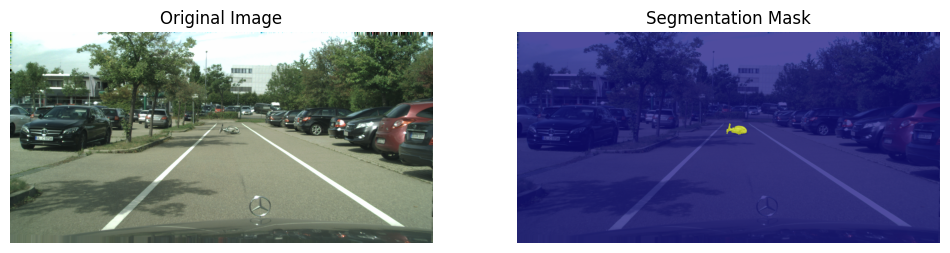

Image shape: torch.Size([3, 1024, 2048])
Mask shape: torch.Size([1, 1024, 2048])


In [229]:
dataset_train = LostAndFound('/content/laf_data/laf_train', binarize=True, device=str(DEVICE))
dataset_test = LostAndFound('/content/laf_data/laf_test', binarize=True, device=str(DEVICE))

train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4)
test_loader  = DataLoader(dataset_test, batch_size=4, shuffle=False, num_workers=4)

idx = 199
dataset_train.visualize(idx)

img, mask = dataset_train[idx]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

# Model

In [223]:
""" MODEL DEFINITION
  Create model for Cityscapes with 7 grouped classes + objectness
  As mentioned in the paper:
  1. "road"
  2. "flat(w/o road)"
  3. "human"
  4. "vehicle"
  5. "construction"
  6. "object"
  7. "background"
"""

model = DeepLabV3_SigmoidHead(num_classes=7, weights_path=model_weights)
model = model.to(DEVICE)

# Unknown Objectness Score (UOS): Random Sample Visualization

Random Indices: [975, 868, 940]


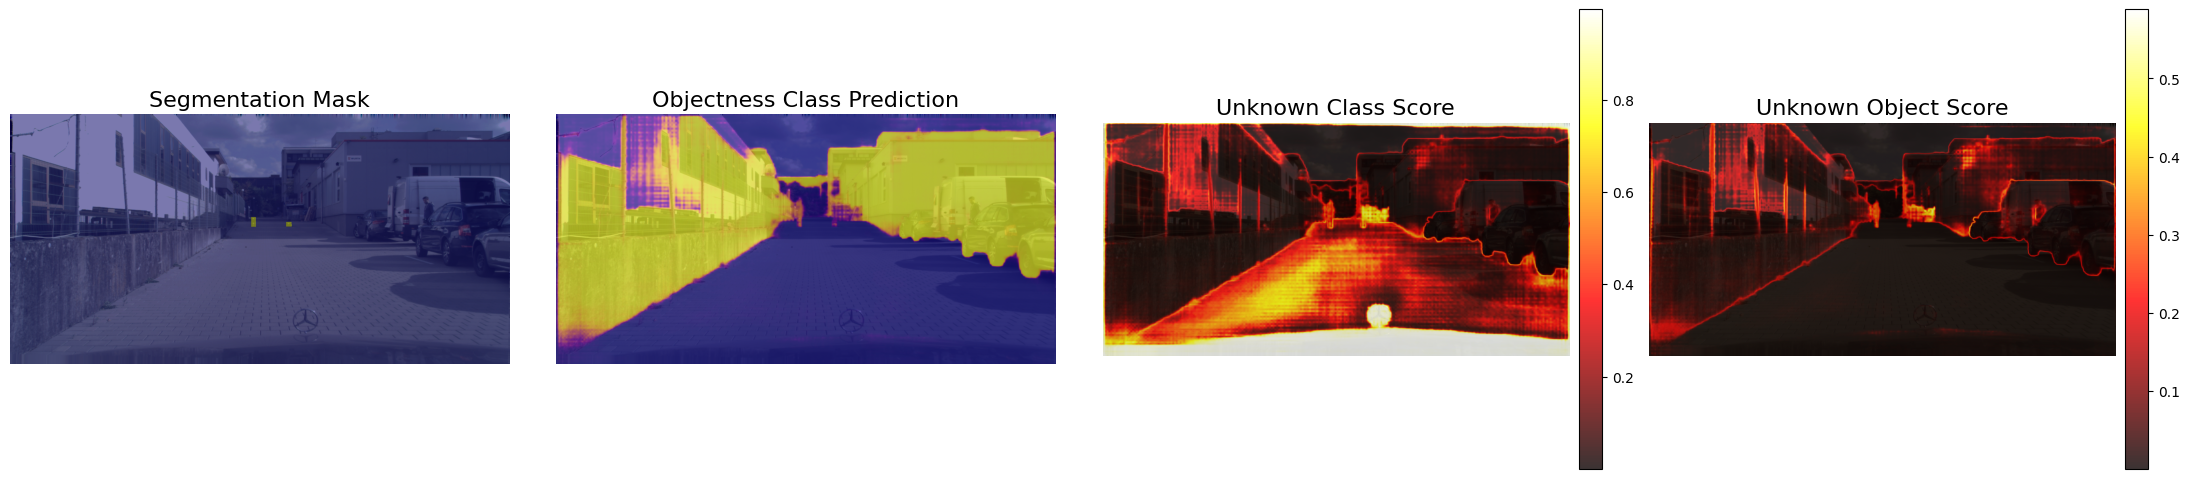

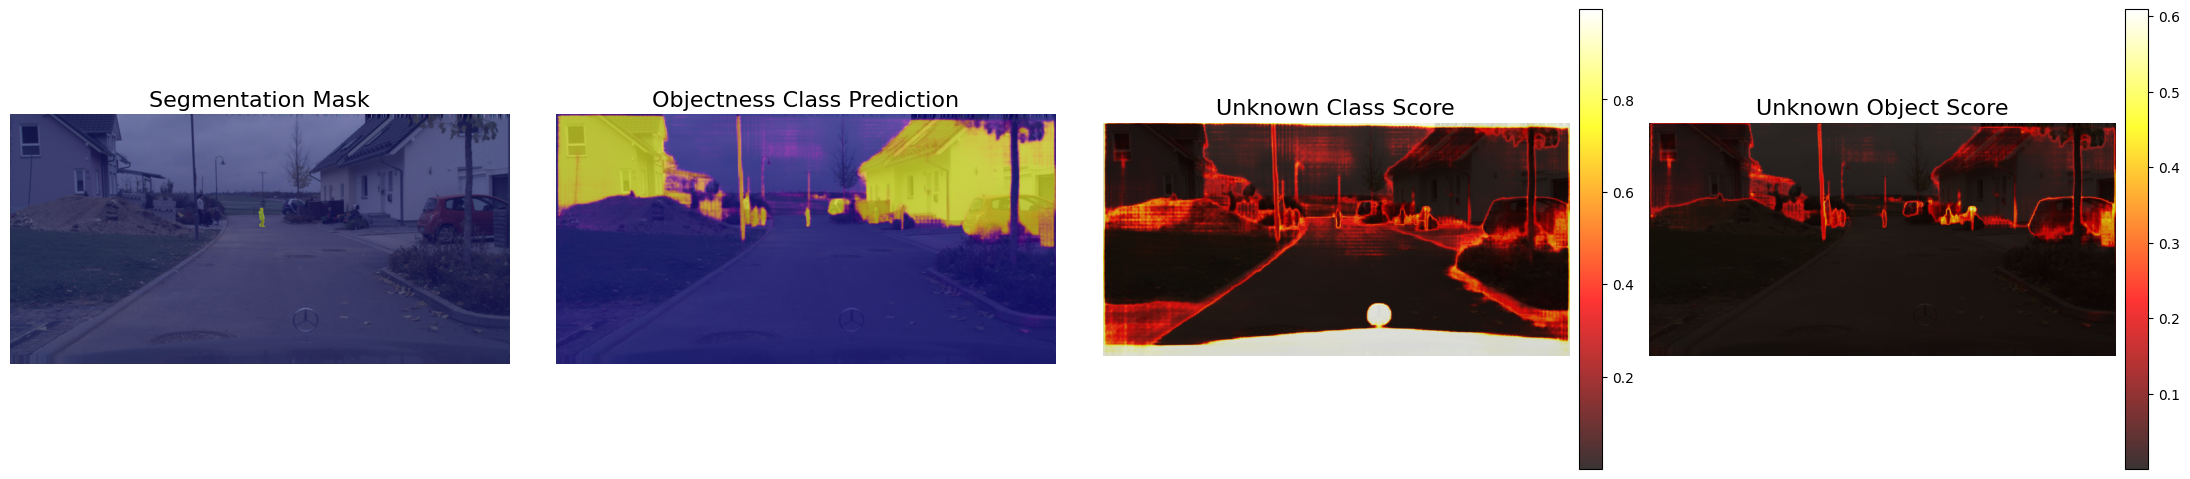

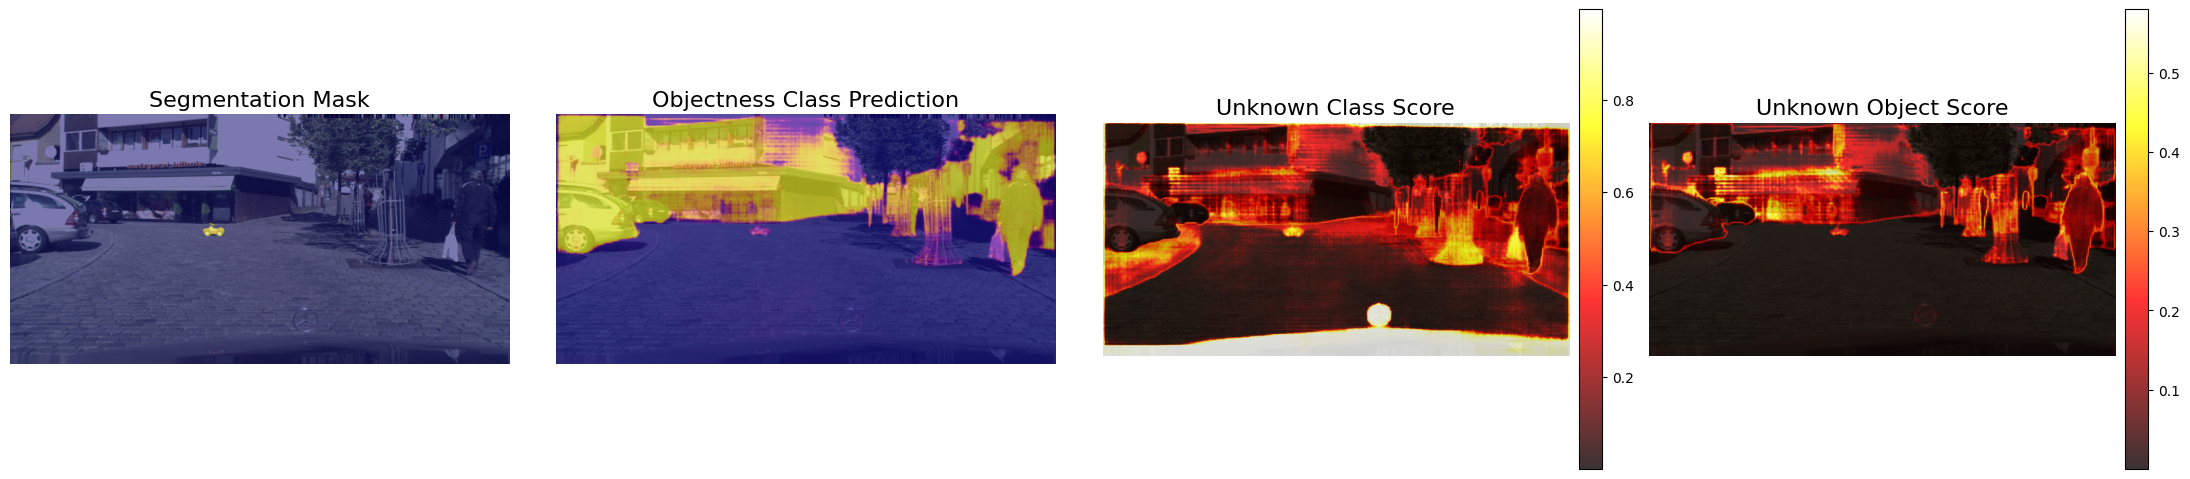

In [230]:
df = dataset_test

import random
indices = random.sample(range(len(dataset_train)), 3)
print(f"Random Indices: {indices}")

for idx in indices:
  image, mask = df[idx]
  unkown_obj_score, unknown_score, objectness_score, pred_mask = model.unknown_obj_scores(image, uos_only=False)
  df.visualize_uos(idx, unkown_obj_score, unknown_score, objectness_score)


# TODO: Conformal Risk Control Calibration using LostAndFound training set

# TODO: UOS Evaluation using LostAndFound Test Set

#fn CONTROL

In [ ]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')

data = np.load('../data/polyps/polyps-pranet.npz')
example_paths = os.listdir('../data/polyps/examples')

sgmd = data['sgmd'] # sigmoid scores
gt_masks = data['targets']
example_indexes = data['example_indexes']

In [ ]:
print("sgmd shape:", sgmd.shape)
print("gt_masks shape:", gt_masks.shape)
print("uos:",unk_obj_score.shape)


sgmd shape: (1798, 352, 352)
gt_masks shape: (1798, 352, 352)


NameError: name 'unk_obj_score' is not defined

In [ ]:
# Problem setup
n=500 # number of calibration points
alpha = 0.1 # 1-alpha is the desired false negative rate

def false_negative_rate(pred_masks, true_masks):
    return 1-((pred_masks * true_masks).sum(axis=1).sum(axis=1)/true_masks.sum(axis=1).sum(axis=1)).mean()

In [ ]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (sgmd.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_sgmd, val_sgmd = sgmd[idx,:], sgmd[~idx,:]
cal_gt_masks, val_gt_masks = gt_masks[idx], gt_masks[~idx]

### Conformal risk control happens here

In [ ]:
# Run the conformal risk control procedure
def lamhat_threshold(lam): return false_negative_rate(cal_sgmd>=lam, cal_gt_masks) - ((n+1)/n*alpha - 1/n)
lamhat = brentq(lamhat_threshold, 0, 1)
predicted_masks = val_sgmd >= lamhat

In [ ]:
# Calculate empirical FNR
print(f"The empirical FNR is: {false_negative_rate(predicted_masks, val_gt_masks)} and the threshold value is: {lamhat}")

The empirical FNR is: 0.09701384782974165 and the threshold value is: 0.43368619680439285


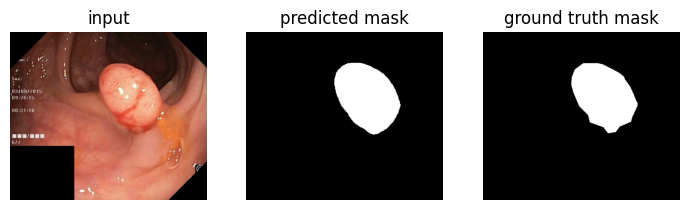

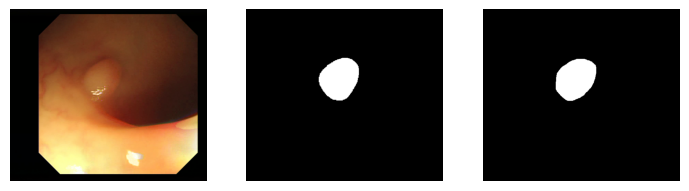

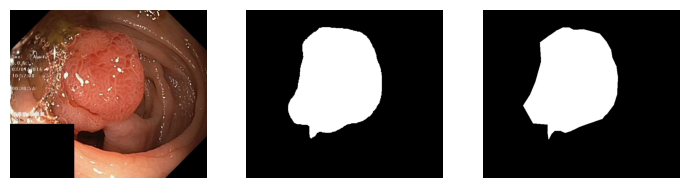

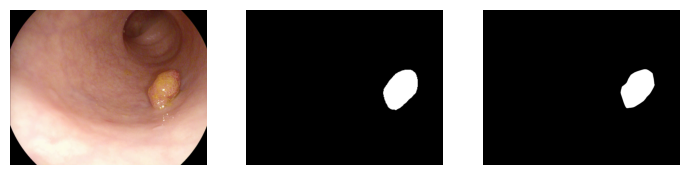

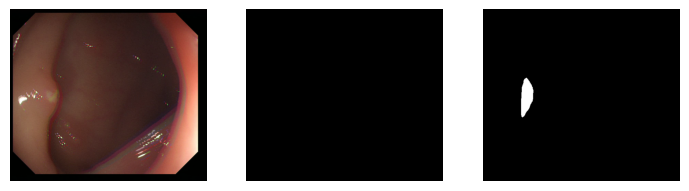

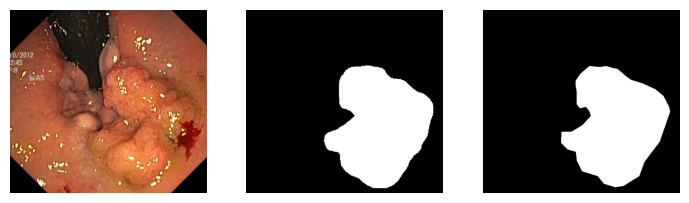

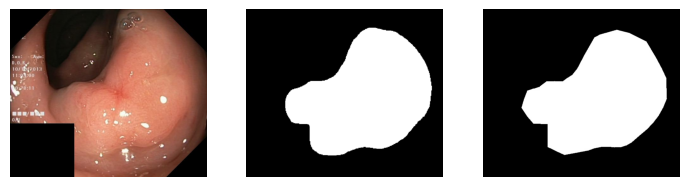

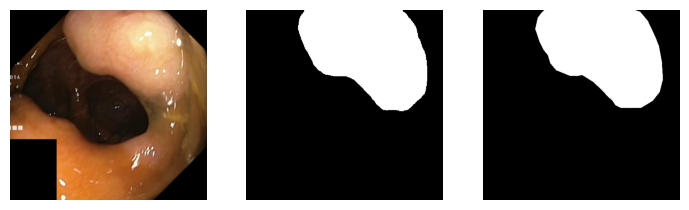

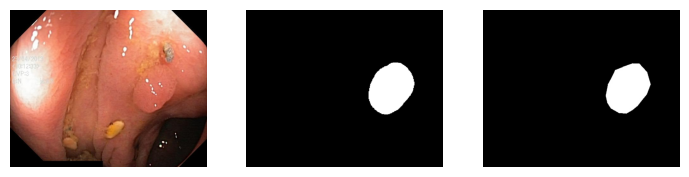

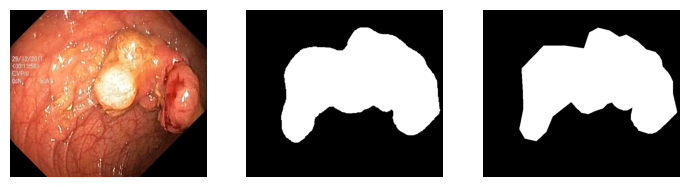

In [ ]:
# Show some examples
for i in range(10):
    rand_idx = np.random.choice(example_indexes)
    img = imread('../data/polyps/examples/' + str(rand_idx) + '.jpg')
    gt_mask = imread('../data/polyps/examples/' + str(rand_idx) + '_gt_mask.jpg')
    predicted_mask = resize(sgmd[rand_idx] > lamhat, (img.shape[0],img.shape[1]), anti_aliasing=False)
    fig, axs = plt.subplots(1,3,figsize=(8.64,4.76))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[1].imshow(predicted_mask, cmap='gray')
    axs[1].axis('off')
    axs[2].imshow(gt_mask, cmap='gray')
    axs[2].axis('off')
    if i == 0:
        axs[0].set_title('input')
        axs[1].set_title('predicted mask')
        axs[2].set_title('ground truth mask')
    plt.show()

This method was first introduced here: https://arxiv.org/abs/2208.02814.